### Hybrid Variational Neural Network for Fano fitting (Quantum-Classical Variational Neural Network)

<p>Perform a regression to fit a Fano resonance with Pennylane framework</p>

<p> Let's fit a <a href="https://en.wikipedia.org/wiki/Fano_resonance">Fano resonance</a>, this signal appears on superconducting resonators when photons<sup><a href="https://arxiv.org/abs/2207.03829">[1]</a></sup> interact with spins at low temperatures (from 4K to 10mK in a dilution refrigerator)</p>

#### References:

> https://arxiv.org/abs/2207.03829
>
> https://qiskit.org/textbook/ch-applications/vqe-molecules.html

In [1]:
import tensorflow as tf

from qiskit import QuantumCircuit, Aer, execute
from math import asin, sqrt, ceil
from qiskit.opflow import Z, CircuitStateFn, StateFn, PauliExpectation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter
from scipy.signal import detrend
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Layer, ReLU
import logging
import warnings

warnings.filterwarnings('ignore')
logging.getLogger('tensorflow').setLevel(logging.ERROR)

%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 7]
%config InlineBackend.figure_format = 'retina'

In [2]:
tf.executing_eagerly()

True

In [3]:
fano_data = pd.read_csv("./datasets/signal_080_peak_1_fano_adjust.csv")

In [4]:
def func_fano(x, xc, w, q, y0):
    y = y0+A*(2*(x-xc)/w+q)*(2*(x-xc)/w+q)/(2*(x-xc)/w*2*(x-xc)/w+1)/(1+q*q)
    return y

def scale(arr, lvalue = -np.pi, rvalue = np.pi):
    return np.interp(arr, (arr.min(), arr.max()), (lvalue, rvalue))

def remove_outlier(df_in, col_name, quartiles, rng_arr):
    q1 = df_in[col_name].quantile(quartiles[0])
    q3 = df_in[col_name].quantile(quartiles[1])
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-rng_arr[0]*iqr
    fence_high = q3+rng_arr[1]*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [5]:
def smooth(data):
    #return data
    #return scipy.ndimage.gaussian_filter(data, sigma=30, mode='reflect', truncate=18.0)
    
    return gaussian_filter(data, sigma=15, mode='reflect', truncate=18.0)
    #return scipy.ndimage.gaussian_filter(data, sigma=15, mode='reflect', truncate=15.0)

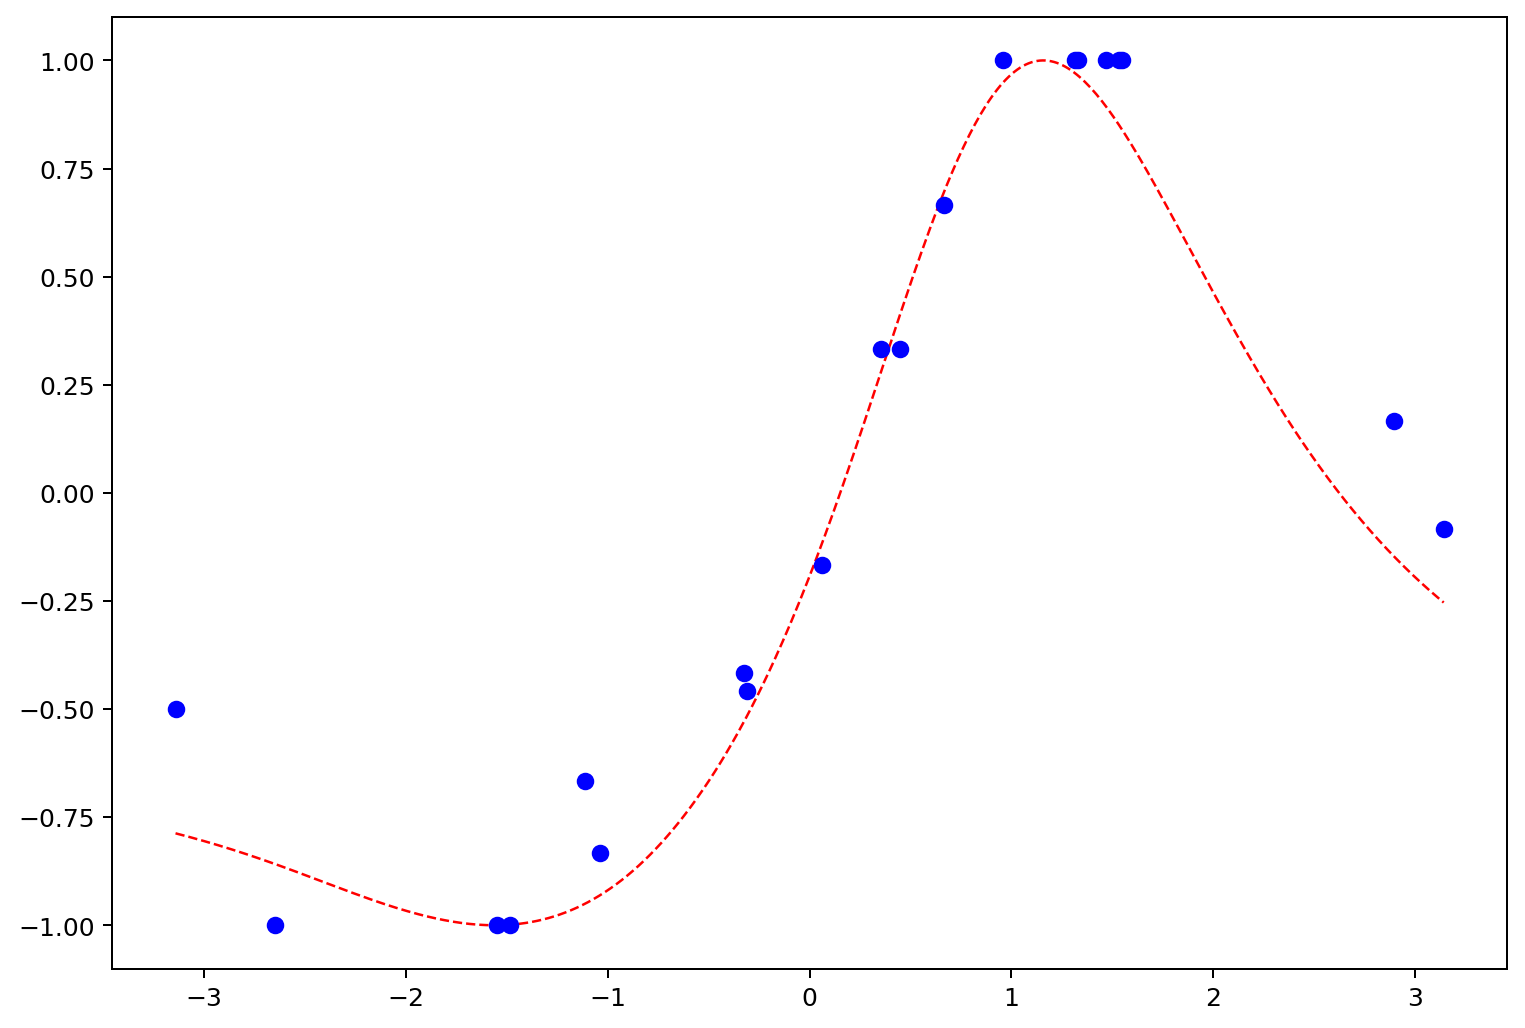

In [6]:
num_samples = 20
eps = 0.2
lb, ub = -1, 1

y0 = fano_data["y0"].values[0]
A = fano_data["A"].values[0]
xc = fano_data["xc"].values[0]
q = fano_data["q"].values[0]
w = fano_data["w"].values[0]

f = lambda x: func_fano(x, xc, w, q, y0)

X_ = fano_data["signal_original_x"].values.reshape(-1,1)

# Create Gaussian distribution (mean = 0, std = 1)
std_scaler = StandardScaler()
std_scaler.fit(X_)
X_ = std_scaler.transform(X_)

#y_ = f(X_)

y_ = fano_data["signal_original_y"].values

# select a better range of data to fit
rng = range(250,700)

X_ = X_.take(rng, axis=0)
y_ = y_.take(rng, axis=0)

# random indices for points selection
#indices = sorted(np.random.choice(range(X_.shape[0]), num_samples, replace=False))

#indices = np.array([19,  40, 156, 159, 173, 175, 191, 207, 213, 253, 358, 359, 448, 543, 559, 613, 651, 657, 737, 754])
indices = [22, 54, 125, 129, 153, 158, 204, 205, 229, 248, 254, 268, 287, 310, 311, 320, 324, 325, 412, 428]

XX = X_[indices].reshape(-1,1)
yy = y_[indices].reshape(-1,1)

#df = pd.DataFrame(zip(X[:,0].flatten().tolist(), y[:,0].flatten().tolist()), columns = ["X", "y"])
#new_df = remove_outlier(df, "y", [0.25, 0.75], [0.05, 0.05])
#X = new_df["X"].values.reshape(-1,1)
#y = new_df["y"].values.reshape(-1,1)

yy = detrend(yy)

#XX = scale(XX, 0, 1)
XX = scale(XX) # from -pi to pi
yy = scale(yy, -1, 1)

#X_ = scale(X_, 0, 1)
X_ = scale(X_) # from -pi to pi
y_ = scale(y_, -1, 1)

plt.figure(num = "Fano adjust data", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')
plt.plot(X_, y_, "r--", label='Tx signal', linewidth = 1)
plt.plot(XX, yy, "bo", label = 'Points to fit')
plt.show()

In [7]:
def prob_to_angle(prob):
    return 2*asin(sqrt(prob))

In [8]:
def quantum_layer2(initial_parameters, num_qubits):
   
    simulator = Aer.get_backend('qasm_simulator')
    shots = 4096

    expectations = []
    
    for i in range(len(initial_parameters)):
        
        quantumCircuit = QuantumCircuit(num_qubits)

        quantumCircuit.h(range(num_qubits))
    
        angles = initial_parameters[i]
        
        for j in range(len(angles)):
            #quantumCircuit.ry(prob_to_angle(float(angles[j])), j)
            #quantumCircuit.ry(angles[j] * np.pi, j)
            quantumCircuit.ry(angles[j], j)
   
        quantumCircuit.measure_all()

        job = execute(quantumCircuit, backend=simulator, shots=shots)
        result = job.result().get_counts(quantumCircuit)

        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)

        # Compute probabilities for each state
        probabilities = counts / shots
        
        # Get state expectation
        expectation_value = np.sum(states * probabilities)
        
        expectations.append(expectation_value)

    diff = num_qubits - len(expectations)
    
    if diff > 0:
        for _ in range(diff):
            expectations.append(0)
            
    return np.array(expectations)

In [9]:
def quantum_layer(initial_parameters, num_qubits):

    expectations = []
    
    for i in range(len(initial_parameters)):
        
        quantumCircuit = QuantumCircuit(num_qubits)

        quantumCircuit.h(range(num_qubits))
    
        angles = initial_parameters[i]
        
        for j in range(len(angles)):
            #quantumCircuit.ry(prob_to_angle(float(angles[j])), j)
            #quantumCircuit.ry(angles[j] * np.pi, j)
            quantumCircuit.ry(angles[j], j)

        #quantumCircuit.h(range(num_qubits))
 
        operator = Z
        for _ in range(num_qubits - 1):
            operator @= Z
          
        psi = StateFn(quantumCircuit)
        #psi = CircuitStateFn(quantumCircuit)
        #expectation_value = psi.adjoint().compose(operator).compose(psi).eval() 
        expectation_value = (~psi @ operator @ psi).eval()
        #expectation_value = PauliExpectation().convert(expectation_value).eval()

        expectations.append(expectation_value)
 
    diff = num_qubits - len(expectations)
    
    if diff > 0:
        for _ in range(diff):
            expectations.append(0j)
    
    return expectations

In [10]:
class Linear(Layer):
    
    def __init__(self, output_size, batch_size = 10, units = 1, input_dim=1, num_qubits = 1, **kwargs):
        
        super(Linear, self).__init__(**kwargs)
        
        #self.threshold = 0.1
        self.num_qubits = num_qubits
        self.output_size = output_size
        self.dense = tf.keras.layers.Dense(num_qubits, name='internal_dense')
        self.w = self.add_weight(
            shape=(input_dim, units), initializer="random_normal", trainable=True
        )
        
        self.b = self.add_weight(shape=(units,), initializer="zeros", trainable=True)

    def build(self, input_shape): 
        self.input_size = input_shape[1]        
        self.w = self.add_weight(shape=(self.input_size, self.output_size), initializer='random_normal', trainable=True)
        super(Linear, self).build(input_shape)
        
    def get_config(self):
        config = super(Linear, self).get_config()
        return config

    def compute_output_shape(self, input_shape):
        assert isinstance(input_shape, list)
        shape_a, shape_b = input_shape
        return [shape_a, shape_b]
    
    def call(self, inputs):
        
        if (tf.executing_eagerly()):
            
            final_output = []
        
            for i in range(inputs.shape[0]):
                pred = quantum_layer2(inputs.numpy(), self.num_qubits)
                final_output.append(list(pred))
            
            #out_layer = tf.keras.layers.Dense(self.num_qubits, activation='relu')
            
            return tf.convert_to_tensor(final_output)
        
        #return tf.sigmoid(tf.add(tf.matmul(inputs, self.w**2), self.b))
        #x = self.dense(inputs)
        return inputs

In [11]:
n_qubits = 1

In [12]:
def sequential_model():

    layers_arr = []
    layers_arr.append(Dense(n_qubits, activation = 'linear', input_shape = [1], name = "dense1"))
    layers_arr.append(Linear(output_size = n_qubits, units = 1, input_dim = n_qubits, num_qubits = n_qubits, name = "quantum1"))
    #layers_arr.append(Dense(1, activation="linear", name = "dense2"))   
    layers_arr.append(Dense(1, name ="dense3"))

    return Sequential(layers_arr)

In [13]:
model = sequential_model()

#optimizer = Adam(learning_rate=0.01)
optimizer = SGD(learning_rate=0.01)

#model.compile(loss='mse', optimizer = optimizer, metrics = ['mae', 'mse', 'acc'], run_eagerly=True)
model.compile(optimizer, loss='mse', metrics=["accuracy"], run_eagerly=True)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               (None, 1)                 2         
_________________________________________________________________
quantum1 (Linear)            (None, 1)                 2         
_________________________________________________________________
dense3 (Dense)               (None, 1)                 2         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(XX, yy, epochs = 300, batch_size=n_qubits, validation_split = 0.25)

#history = model.fit(XX, yy, epochs = 50, batch_size=n_qubits, validation_split = 0.25)

Epoch 1/300
15/15 [==============================] - 1s 27ms/step - loss: 1.0829 - accuracy: 0.0000e+00 - val_loss: 0.7603 - val_accuracy: 0.0000e+00
Epoch 2/300
15/15 [==============================] - 0s 24ms/step - loss: 0.8891 - accuracy: 0.0000e+00 - val_loss: 0.8546 - val_accuracy: 0.0000e+00
Epoch 3/300
11/15 [=====================>........] - ETA: 0s - loss: 0.7157 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 23ms/step - loss: 0.7811 - accuracy: 0.0000e+00 - val_loss: 0.8926 - val_accuracy: 0.0000e+00
Epoch 4/300
15/15 [==============================] - 0s 23ms/step - loss: 0.7148 - accuracy: 0.0000e+00 - val_loss: 0.9092 - val_accuracy: 0.0000e+00
Epoch 5/300
15/15 [==============================] - 0s 23ms/step - loss: 0.6644 - accuracy: 0.0000e+00 - val_loss: 0.9171 - val_accuracy: 0.0000e+00
Epoch 6/300
 9/15 [=================>............] - ETA: 0s - loss: 0.5639 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 23ms/step - loss: 0.6235 - accuracy: 0.0000e+00 - val_loss: 0.9085 - val_accuracy: 0.0000e+00
Epoch 7/300
15/15 [==============================] - 0s 24ms/step - loss: 0.5894 - accuracy: 0.0000e+00 - val_loss: 0.8791 - val_accuracy: 0.0000e+00
Epoch 8/300
15/15 [==============================] - 0s 24ms/step - loss: 0.5586 - accuracy: 0.0000e+00 - val_loss: 0.8406 - val_accuracy: 0.0000e+00
Epoch 9/300
 4/15 [=======>......................] - ETA: 0s - loss: 0.6079 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 24ms/step - loss: 0.5291 - accuracy: 0.0000e+00 - val_loss: 0.7926 - val_accuracy: 0.0000e+00
Epoch 10/300
15/15 [==============================] - 0s 24ms/step - loss: 0.5033 - accuracy: 0.0000e+00 - val_loss: 0.7655 - val_accuracy: 0.0000e+00
Epoch 11/300
15/15 [==============================] - 0s 23ms/step - loss: 0.4789 - accuracy: 0.0000e+00 - val_loss: 0.7328 - val_accuracy: 0.0000e+00
Epoch 12/300
 1/15 [=>............................] - ETA: 0s - loss: 0.1345 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 22ms/step - loss: 0.4539 - accuracy: 0.0000e+00 - val_loss: 0.6965 - val_accuracy: 0.0000e+00
Epoch 13/300
15/15 [==============================] - 0s 23ms/step - loss: 0.4314 - accuracy: 0.0000e+00 - val_loss: 0.6584 - val_accuracy: 0.0000e+00
Epoch 14/300
15/15 [==============================] - 0s 23ms/step - loss: 0.4102 - accuracy: 0.0000e+00 - val_loss: 0.6385 - val_accuracy: 0.0000e+00
Epoch 15/300


15/15 [==============================] - 0s 23ms/step - loss: 0.3923 - accuracy: 0.0000e+00 - val_loss: 0.6000 - val_accuracy: 0.0000e+00
Epoch 16/300
15/15 [==============================] - 0s 27ms/step - loss: 0.3721 - accuracy: 0.0000e+00 - val_loss: 0.5689 - val_accuracy: 0.0000e+00
Epoch 17/300
11/15 [=====================>........] - ETA: 0s - loss: 0.3888 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 23ms/step - loss: 0.3538 - accuracy: 0.0000e+00 - val_loss: 0.5480 - val_accuracy: 0.0000e+00
Epoch 18/300
15/15 [==============================] - 0s 23ms/step - loss: 0.3366 - accuracy: 0.0000e+00 - val_loss: 0.5165 - val_accuracy: 0.0000e+00
Epoch 19/300
15/15 [==============================] - 0s 23ms/step - loss: 0.3202 - accuracy: 0.0000e+00 - val_loss: 0.4846 - val_accuracy: 0.0000e+00
Epoch 20/300
 9/15 [=================>............] - ETA: 0s - loss: 0.2762 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 21ms/step - loss: 0.3043 - accuracy: 0.0000e+00 - val_loss: 0.4503 - val_accuracy: 0.0000e+00
Epoch 21/300
15/15 [==============================] - 0s 22ms/step - loss: 0.2930 - accuracy: 0.0000e+00 - val_loss: 0.4292 - val_accuracy: 0.0000e+00
Epoch 22/300
15/15 [==============================] - 0s 24ms/step - loss: 0.2777 - accuracy: 0.0000e+00 - val_loss: 0.4052 - val_accuracy: 0.0000e+00
Epoch 23/300
 7/15 [=============>................] - ETA: 0s - loss: 0.2593 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 22ms/step - loss: 0.2646 - accuracy: 0.0000e+00 - val_loss: 0.3849 - val_accuracy: 0.0000e+00
Epoch 24/300
15/15 [==============================] - 0s 22ms/step - loss: 0.2500 - accuracy: 0.0000e+00 - val_loss: 0.3652 - val_accuracy: 0.0000e+00
Epoch 25/300
15/15 [==============================] - 0s 23ms/step - loss: 0.2407 - accuracy: 0.0000e+00 - val_loss: 0.3480 - val_accuracy: 0.0000e+00
Epoch 26/300
 4/15 [=======>......................] - ETA: 0s - loss: 0.4748 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 22ms/step - loss: 0.2319 - accuracy: 0.0000e+00 - val_loss: 0.3304 - val_accuracy: 0.0000e+00
Epoch 27/300
15/15 [==============================] - 0s 22ms/step - loss: 0.2197 - accuracy: 0.0000e+00 - val_loss: 0.3151 - val_accuracy: 0.0000e+00
Epoch 28/300
15/15 [==============================] - 0s 23ms/step - loss: 0.2097 - accuracy: 0.0000e+00 - val_loss: 0.2978 - val_accuracy: 0.0000e+00
Epoch 29/300
 1/15 [=>............................] - ETA: 0s - loss: 0.0020 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 23ms/step - loss: 0.2013 - accuracy: 0.0000e+00 - val_loss: 0.2799 - val_accuracy: 0.0000e+00
Epoch 30/300
15/15 [==============================] - 0s 23ms/step - loss: 0.1930 - accuracy: 0.0000e+00 - val_loss: 0.2696 - val_accuracy: 0.0000e+00
Epoch 31/300
15/15 [==============================] - 0s 24ms/step - loss: 0.1839 - accuracy: 0.0000e+00 - val_loss: 0.2579 - val_accuracy: 0.0000e+00


Epoch 32/300
15/15 [==============================] - 0s 26ms/step - loss: 0.1770 - accuracy: 0.0000e+00 - val_loss: 0.2428 - val_accuracy: 0.0000e+00
Epoch 33/300
15/15 [==============================] - 0s 23ms/step - loss: 0.1701 - accuracy: 0.0000e+00 - val_loss: 0.2306 - val_accuracy: 0.0000e+00
Epoch 34/300
11/15 [=====================>........] - ETA: 0s - loss: 0.1930 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 23ms/step - loss: 0.1632 - accuracy: 0.0000e+00 - val_loss: 0.2157 - val_accuracy: 0.0000e+00
Epoch 35/300
15/15 [==============================] - 0s 23ms/step - loss: 0.1564 - accuracy: 0.0000e+00 - val_loss: 0.2076 - val_accuracy: 0.0000e+00
Epoch 36/300
15/15 [==============================] - 0s 23ms/step - loss: 0.1500 - accuracy: 0.0000e+00 - val_loss: 0.1958 - val_accuracy: 0.0000e+00
Epoch 37/300
 8/15 [===============>..............] - ETA: 0s - loss: 0.1893 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 23ms/step - loss: 0.1458 - accuracy: 0.0000e+00 - val_loss: 0.1846 - val_accuracy: 0.0000e+00
Epoch 38/300
15/15 [==============================] - 0s 22ms/step - loss: 0.1389 - accuracy: 0.0000e+00 - val_loss: 0.1755 - val_accuracy: 0.0000e+00
Epoch 39/300
15/15 [==============================] - 0s 22ms/step - loss: 0.1338 - accuracy: 0.0000e+00 - val_loss: 0.1681 - val_accuracy: 0.0000e+00
Epoch 40/300
 4/15 [=======>......................] - ETA: 0s - loss: 0.0257 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 23ms/step - loss: 0.1294 - accuracy: 0.0000e+00 - val_loss: 0.1597 - val_accuracy: 0.0000e+00
Epoch 41/300
15/15 [==============================] - 0s 22ms/step - loss: 0.1238 - accuracy: 0.0000e+00 - val_loss: 0.1511 - val_accuracy: 0.6000
Epoch 42/300
15/15 [==============================] - 0s 22ms/step - loss: 0.1194 - accuracy: 0.0667 - val_loss: 0.1447 - val_accuracy: 0.6000
Epoch 43/300
 4/15 [=======>......................] - ETA: 0s - loss: 0.0244 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 23ms/step - loss: 0.1149 - accuracy: 0.0000e+00 - val_loss: 0.1372 - val_accuracy: 0.6000
Epoch 44/300
15/15 [==============================] - 0s 23ms/step - loss: 0.1105 - accuracy: 0.0667 - val_loss: 0.1285 - val_accuracy: 0.6000
Epoch 45/300
15/15 [==============================] - 0s 23ms/step - loss: 0.1078 - accuracy: 0.1333 - val_loss: 0.1219 - val_accuracy: 0.6000
Epoch 46/300
 1/15 [=>............................] - ETA: 0s - loss: 0.0067 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 23ms/step - loss: 0.1059 - accuracy: 0.1333 - val_loss: 0.1133 - val_accuracy: 0.6000
Epoch 47/300
15/15 [==============================] - 0s 27ms/step - loss: 0.0999 - accuracy: 0.1333 - val_loss: 0.1116 - val_accuracy: 0.6000
Epoch 48/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0997 - accuracy: 0.1333 - val_loss: 0.1055 - val_accuracy: 0.6000
Epoch 49/300
 1/15 [=>............................] - ETA: 0s - loss: 0.2803 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 23ms/step - loss: 0.0942 - accuracy: 0.1333 - val_loss: 0.0980 - val_accuracy: 0.6000
Epoch 50/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0924 - accuracy: 0.1333 - val_loss: 0.0923 - val_accuracy: 0.6000
Epoch 51/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0893 - accuracy: 0.1333 - val_loss: 0.0902 - val_accuracy: 0.6000


Epoch 52/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0868 - accuracy: 0.1333 - val_loss: 0.0858 - val_accuracy: 0.6000
Epoch 53/300
15/15 [==============================] - 0s 22ms/step - loss: 0.0836 - accuracy: 0.1333 - val_loss: 0.0799 - val_accuracy: 0.6000
Epoch 54/300
10/15 [===================>..........] - ETA: 0s - loss: 0.0906 - accuracy: 0.1000    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 24ms/step - loss: 0.0822 - accuracy: 0.1333 - val_loss: 0.0761 - val_accuracy: 0.6000
Epoch 55/300
15/15 [==============================] - 0s 24ms/step - loss: 0.0776 - accuracy: 0.2000 - val_loss: 0.0712 - val_accuracy: 0.6000
Epoch 56/300
15/15 [==============================] - 0s 25ms/step - loss: 0.0774 - accuracy: 0.2000 - val_loss: 0.0701 - val_accuracy: 0.6000
Epoch 57/300
 7/15 [=============>................] - ETA: 0s - loss: 0.0666 - accuracy: 0.1429    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 26ms/step - loss: 0.0746 - accuracy: 0.2000 - val_loss: 0.0655 - val_accuracy: 0.6000
Epoch 58/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0739 - accuracy: 0.2000 - val_loss: 0.0627 - val_accuracy: 0.6000
Epoch 59/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0730 - accuracy: 0.2000 - val_loss: 0.0588 - val_accuracy: 0.6000
Epoch 60/300
 4/15 [=======>......................] - ETA: 0s - loss: 0.0337 - accuracy: 0.2500    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 23ms/step - loss: 0.0723 - accuracy: 0.2000 - val_loss: 0.0571 - val_accuracy: 0.6000
Epoch 61/300
15/15 [==============================] - 0s 24ms/step - loss: 0.0672 - accuracy: 0.2000 - val_loss: 0.0537 - val_accuracy: 0.6000
Epoch 62/300
15/15 [==============================] - 0s 27ms/step - loss: 0.0668 - accuracy: 0.2000 - val_loss: 0.0515 - val_accuracy: 0.6000
Epoch 63/300
 1/15 [=>............................] - ETA: 0s - loss: 0.1624 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 23ms/step - loss: 0.0670 - accuracy: 0.2000 - val_loss: 0.0482 - val_accuracy: 0.6000
Epoch 64/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0648 - accuracy: 0.2000 - val_loss: 0.0459 - val_accuracy: 0.6000
Epoch 65/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0618 - accuracy: 0.2000 - val_loss: 0.0447 - val_accuracy: 0.6000
Epoch 66/300


15/15 [==============================] - 0s 23ms/step - loss: 0.0611 - accuracy: 0.2000 - val_loss: 0.0429 - val_accuracy: 0.6000
Epoch 67/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0633 - accuracy: 0.2000 - val_loss: 0.0405 - val_accuracy: 0.6000
Epoch 68/300
13/15 [=========================>....] - ETA: 0s - loss: 0.0537 - accuracy: 0.1538WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 23ms/step - loss: 0.0617 - accuracy: 0.2000 - val_loss: 0.0383 - val_accuracy: 0.6000
Epoch 69/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0598 - accuracy: 0.2000 - val_loss: 0.0374 - val_accuracy: 0.6000
Epoch 70/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0586 - accuracy: 0.2000 - val_loss: 0.0361 - val_accuracy: 0.6000
Epoch 71/300
10/15 [===================>..........] - ETA: 0s - loss: 0.0637 - accuracy: 0.2000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 24ms/step - loss: 0.0564 - accuracy: 0.2000 - val_loss: 0.0341 - val_accuracy: 0.6000
Epoch 72/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0562 - accuracy: 0.2000 - val_loss: 0.0330 - val_accuracy: 0.6000
Epoch 73/300
15/15 [==============================] - 0s 28ms/step - loss: 0.0548 - accuracy: 0.2000 - val_loss: 0.0304 - val_accuracy: 0.6000
Epoch 74/300
 8/15 [===============>..............] - ETA: 0s - loss: 0.0767 - accuracy: 0.1250WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 23ms/step - loss: 0.0536 - accuracy: 0.2000 - val_loss: 0.0284 - val_accuracy: 0.6000
Epoch 75/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0527 - accuracy: 0.2000 - val_loss: 0.0287 - val_accuracy: 0.6000
Epoch 76/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0537 - accuracy: 0.2000 - val_loss: 0.0285 - val_accuracy: 0.6000
Epoch 77/300
 4/15 [=======>......................] - ETA: 0s - loss: 0.0394 - accuracy: 0.2500    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 27ms/step - loss: 0.0543 - accuracy: 0.2000 - val_loss: 0.0274 - val_accuracy: 0.6000
Epoch 78/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0528 - accuracy: 0.2000 - val_loss: 0.0259 - val_accuracy: 0.6000
Epoch 79/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0517 - accuracy: 0.2000 - val_loss: 0.0241 - val_accuracy: 0.6000
Epoch 80/300
 1/15 [=>............................] - ETA: 0s - loss: 0.0171 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 23ms/step - loss: 0.0523 - accuracy: 0.2000 - val_loss: 0.0223 - val_accuracy: 0.6000
Epoch 81/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0524 - accuracy: 0.2000 - val_loss: 0.0216 - val_accuracy: 0.6000
Epoch 82/300
15/15 [==============================] - 0s 22ms/step - loss: 0.0493 - accuracy: 0.2000 - val_loss: 0.0208 - val_accuracy: 0.6000
Epoch 83/300
 1/15 [=>............................] - ETA: 0s - loss: 0.0427 - accuracy: 1.0000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 23ms/step - loss: 0.0499 - accuracy: 0.2000 - val_loss: 0.0194 - val_accuracy: 0.6000
Epoch 84/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0512 - accuracy: 0.2000 - val_loss: 0.0183 - val_accuracy: 0.6000
Epoch 85/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0503 - accuracy: 0.2000 - val_loss: 0.0176 - val_accuracy: 0.6000
Epoch 86/300


15/15 [==============================] - 0s 23ms/step - loss: 0.0490 - accuracy: 0.2000 - val_loss: 0.0169 - val_accuracy: 0.6000
Epoch 87/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0493 - accuracy: 0.2000 - val_loss: 0.0161 - val_accuracy: 0.6000
Epoch 88/300
13/15 [=========================>....] - ETA: 0s - loss: 0.0554 - accuracy: 0.2308WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 23ms/step - loss: 0.0489 - accuracy: 0.2000 - val_loss: 0.0154 - val_accuracy: 0.6000
Epoch 89/300
15/15 [==============================] - 0s 24ms/step - loss: 0.0439 - accuracy: 0.2000 - val_loss: 0.0156 - val_accuracy: 0.6000
Epoch 90/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0462 - accuracy: 0.2000 - val_loss: 0.0143 - val_accuracy: 0.6000
Epoch 91/300
10/15 [===================>..........] - ETA: 0s - loss: 0.0340 - accuracy: 0.2000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 24ms/step - loss: 0.0463 - accuracy: 0.2000 - val_loss: 0.0138 - val_accuracy: 0.6000
Epoch 92/300
15/15 [==============================] - 0s 27ms/step - loss: 0.0488 - accuracy: 0.2000 - val_loss: 0.0140 - val_accuracy: 0.6000
Epoch 93/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0481 - accuracy: 0.2000 - val_loss: 0.0136 - val_accuracy: 0.6000
Epoch 94/300
 7/15 [=============>................] - ETA: 0s - loss: 0.0383 - accuracy: 0.1429WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 23ms/step - loss: 0.0488 - accuracy: 0.2000 - val_loss: 0.0130 - val_accuracy: 0.6000
Epoch 95/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0464 - accuracy: 0.2000 - val_loss: 0.0116 - val_accuracy: 0.6000
Epoch 96/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0465 - accuracy: 0.2000 - val_loss: 0.0113 - val_accuracy: 0.6000
Epoch 97/300
 4/15 [=======>......................] - ETA: 0s - loss: 0.0133 - accuracy: 0.2500    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 23ms/step - loss: 0.0476 - accuracy: 0.2000 - val_loss: 0.0106 - val_accuracy: 0.6000
Epoch 98/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0475 - accuracy: 0.2000 - val_loss: 0.0105 - val_accuracy: 0.6000
Epoch 99/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0489 - accuracy: 0.2000 - val_loss: 0.0105 - val_accuracy: 0.6000
Epoch 100/300
 4/15 [=======>......................] - ETA: 0s - loss: 0.0780 - accuracy: 0.2500    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 24ms/step - loss: 0.0450 - accuracy: 0.2000 - val_loss: 0.0105 - val_accuracy: 0.6000
Epoch 101/300
15/15 [==============================] - 0s 24ms/step - loss: 0.0456 - accuracy: 0.2000 - val_loss: 0.0099 - val_accuracy: 0.6000
Epoch 102/300
15/15 [==============================] - 0s 24ms/step - loss: 0.0435 - accuracy: 0.2000 - val_loss: 0.0094 - val_accuracy: 0.6000
Epoch 103/300
 1/15 [=>............................] - ETA: 0s - loss: 0.0014 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 24ms/step - loss: 0.0463 - accuracy: 0.2000 - val_loss: 0.0093 - val_accuracy: 0.6000
Epoch 104/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0423 - accuracy: 0.2000 - val_loss: 0.0080 - val_accuracy: 0.6000
Epoch 105/300
15/15 [==============================] - 0s 24ms/step - loss: 0.0456 - accuracy: 0.2000 - val_loss: 0.0078 - val_accuracy: 0.6000
Epoch 106/300


15/15 [==============================] - 0s 25ms/step - loss: 0.0419 - accuracy: 0.2000 - val_loss: 0.0081 - val_accuracy: 0.6000
Epoch 107/300
15/15 [==============================] - 0s 27ms/step - loss: 0.0446 - accuracy: 0.2000 - val_loss: 0.0079 - val_accuracy: 0.6000
Epoch 108/300
11/15 [=====================>........] - ETA: 0s - loss: 0.0571 - accuracy: 0.1818WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 23ms/step - loss: 0.0444 - accuracy: 0.2000 - val_loss: 0.0072 - val_accuracy: 0.6000
Epoch 109/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0444 - accuracy: 0.2000 - val_loss: 0.0073 - val_accuracy: 0.6000
Epoch 110/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0418 - accuracy: 0.2000 - val_loss: 0.0070 - val_accuracy: 0.6000
Epoch 111/300
10/15 [===================>..........] - ETA: 0s - loss: 0.0419 - accuracy: 0.2000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 23ms/step - loss: 0.0417 - accuracy: 0.2000 - val_loss: 0.0062 - val_accuracy: 0.6000
Epoch 112/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0455 - accuracy: 0.2000 - val_loss: 0.0057 - val_accuracy: 0.6000
Epoch 113/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0433 - accuracy: 0.2000 - val_loss: 0.0055 - val_accuracy: 0.6000
Epoch 114/300
 8/15 [===============>..............] - ETA: 0s - loss: 0.0425 - accuracy: 0.1250    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 23ms/step - loss: 0.0445 - accuracy: 0.2000 - val_loss: 0.0058 - val_accuracy: 0.6000
Epoch 115/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0433 - accuracy: 0.2000 - val_loss: 0.0052 - val_accuracy: 0.6000
Epoch 116/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0426 - accuracy: 0.2000 - val_loss: 0.0054 - val_accuracy: 0.6000
Epoch 117/300
 5/15 [=========>....................] - ETA: 0s - loss: 0.0453 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 23ms/step - loss: 0.0442 - accuracy: 0.2000 - val_loss: 0.0053 - val_accuracy: 0.6000
Epoch 118/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0444 - accuracy: 0.2000 - val_loss: 0.0054 - val_accuracy: 0.6000
Epoch 119/300
15/15 [==============================] - 0s 22ms/step - loss: 0.0437 - accuracy: 0.2000 - val_loss: 0.0052 - val_accuracy: 0.6000
Epoch 120/300
 4/15 [=======>......................] - ETA: 0s - loss: 0.0560 - accuracy: 0.2500    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 25ms/step - loss: 0.0423 - accuracy: 0.2000 - val_loss: 0.0046 - val_accuracy: 0.6000
Epoch 121/300
15/15 [==============================] - 0s 25ms/step - loss: 0.0431 - accuracy: 0.2000 - val_loss: 0.0051 - val_accuracy: 0.6000
Epoch 122/300
15/15 [==============================] - 0s 27ms/step - loss: 0.0447 - accuracy: 0.2000 - val_loss: 0.0045 - val_accuracy: 0.6000
Epoch 123/300
 1/15 [=>............................] - ETA: 0s - loss: 0.2202 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 23ms/step - loss: 0.0463 - accuracy: 0.2000 - val_loss: 0.0043 - val_accuracy: 0.6000
Epoch 124/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0439 - accuracy: 0.2000 - val_loss: 0.0043 - val_accuracy: 0.6000
Epoch 125/300
15/15 [==============================] - 0s 26ms/step - loss: 0.0453 - accuracy: 0.2000 - val_loss: 0.0042 - val_accuracy: 0.6000
Epoch 126/300


15/15 [==============================] - 0s 23ms/step - loss: 0.0406 - accuracy: 0.2000 - val_loss: 0.0043 - val_accuracy: 0.6000
Epoch 127/300
15/15 [==============================] - 0s 22ms/step - loss: 0.0422 - accuracy: 0.2000 - val_loss: 0.0043 - val_accuracy: 0.6000
Epoch 128/300
12/15 [=======================>......] - ETA: 0s - loss: 0.0481 - accuracy: 0.1667WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 23ms/step - loss: 0.0405 - accuracy: 0.2000 - val_loss: 0.0038 - val_accuracy: 0.6000
Epoch 129/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0457 - accuracy: 0.2000 - val_loss: 0.0036 - val_accuracy: 0.6000
Epoch 130/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0425 - accuracy: 0.2000 - val_loss: 0.0036 - val_accuracy: 0.6000
Epoch 131/300
11/15 [=====================>........] - ETA: 0s - loss: 0.0362 - accuracy: 0.1818WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 23ms/step - loss: 0.0433 - accuracy: 0.2000 - val_loss: 0.0036 - val_accuracy: 0.6000
Epoch 132/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0410 - accuracy: 0.2000 - val_loss: 0.0035 - val_accuracy: 0.6000
Epoch 133/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0452 - accuracy: 0.2000 - val_loss: 0.0038 - val_accuracy: 0.6000
Epoch 134/300
 8/15 [===============>..............] - ETA: 0s - loss: 0.0098 - accuracy: 0.1250WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 23ms/step - loss: 0.0417 - accuracy: 0.2000 - val_loss: 0.0036 - val_accuracy: 0.6000
Epoch 135/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0424 - accuracy: 0.2000 - val_loss: 0.0037 - val_accuracy: 0.6000
Epoch 136/300
15/15 [==============================] - 0s 24ms/step - loss: 0.0412 - accuracy: 0.2000 - val_loss: 0.0033 - val_accuracy: 0.6000
Epoch 137/300
 7/15 [=============>................] - ETA: 0s - loss: 0.0472 - accuracy: 0.1429WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 27ms/step - loss: 0.0441 - accuracy: 0.2000 - val_loss: 0.0033 - val_accuracy: 0.6000
Epoch 138/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0418 - accuracy: 0.2000 - val_loss: 0.0031 - val_accuracy: 0.6000
Epoch 139/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0432 - accuracy: 0.2000 - val_loss: 0.0029 - val_accuracy: 0.6000
Epoch 140/300
 5/15 [=========>....................] - ETA: 0s - loss: 0.0755 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 23ms/step - loss: 0.0421 - accuracy: 0.2000 - val_loss: 0.0025 - val_accuracy: 0.6000
Epoch 141/300
15/15 [==============================] - 0s 22ms/step - loss: 0.0437 - accuracy: 0.2000 - val_loss: 0.0026 - val_accuracy: 0.6000
Epoch 142/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0427 - accuracy: 0.2000 - val_loss: 0.0032 - val_accuracy: 0.6000
Epoch 143/300
 1/15 [=>............................] - ETA: 0s - loss: 0.0949 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 24ms/step - loss: 0.0434 - accuracy: 0.2000 - val_loss: 0.0029 - val_accuracy: 0.6000
Epoch 144/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0417 - accuracy: 0.2000 - val_loss: 0.0030 - val_accuracy: 0.6000
Epoch 145/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0439 - accuracy: 0.2000 - val_loss: 0.0032 - val_accuracy: 0.6000
Epoch 146/300


15/15 [==============================] - 0s 24ms/step - loss: 0.0451 - accuracy: 0.2000 - val_loss: 0.0028 - val_accuracy: 0.6000
Epoch 147/300
15/15 [==============================] - 0s 25ms/step - loss: 0.0442 - accuracy: 0.2000 - val_loss: 0.0031 - val_accuracy: 0.6000
Epoch 148/300
13/15 [=========================>....] - ETA: 0s - loss: 0.0482 - accuracy: 0.2308WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 24ms/step - loss: 0.0434 - accuracy: 0.2000 - val_loss: 0.0029 - val_accuracy: 0.6000
Epoch 149/300
15/15 [==============================] - 0s 24ms/step - loss: 0.0402 - accuracy: 0.2000 - val_loss: 0.0026 - val_accuracy: 0.6000
Epoch 150/300
15/15 [==============================] - 0s 25ms/step - loss: 0.0428 - accuracy: 0.2000 - val_loss: 0.0025 - val_accuracy: 0.6000
Epoch 151/300
10/15 [===================>..........] - ETA: 0s - loss: 0.0377 - accuracy: 0.1000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 31ms/step - loss: 0.0446 - accuracy: 0.2000 - val_loss: 0.0025 - val_accuracy: 0.6000
Epoch 152/300
15/15 [==============================] - 0s 24ms/step - loss: 0.0451 - accuracy: 0.2000 - val_loss: 0.0027 - val_accuracy: 0.6000
Epoch 153/300
15/15 [==============================] - 0s 22ms/step - loss: 0.0444 - accuracy: 0.2000 - val_loss: 0.0024 - val_accuracy: 0.6000
Epoch 154/300
 7/15 [=============>................] - ETA: 0s - loss: 0.0518 - accuracy: 0.2857WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 24ms/step - loss: 0.0403 - accuracy: 0.2000 - val_loss: 0.0027 - val_accuracy: 0.6000
Epoch 155/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0444 - accuracy: 0.2000 - val_loss: 0.0025 - val_accuracy: 0.6000
Epoch 156/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0425 - accuracy: 0.2000 - val_loss: 0.0025 - val_accuracy: 0.6000
Epoch 157/300
 4/15 [=======>......................] - ETA: 0s - loss: 0.0078 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 23ms/step - loss: 0.0448 - accuracy: 0.2000 - val_loss: 0.0024 - val_accuracy: 0.6000
Epoch 158/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0407 - accuracy: 0.2000 - val_loss: 0.0025 - val_accuracy: 0.6000
Epoch 159/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0417 - accuracy: 0.2000 - val_loss: 0.0024 - val_accuracy: 0.6000
Epoch 160/300
 1/15 [=>............................] - ETA: 0s - loss: 0.0073 - accuracy: 1.0000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 23ms/step - loss: 0.0406 - accuracy: 0.2000 - val_loss: 0.0023 - val_accuracy: 0.6000
Epoch 161/300
15/15 [==============================] - 0s 22ms/step - loss: 0.0428 - accuracy: 0.2000 - val_loss: 0.0022 - val_accuracy: 0.6000
Epoch 162/300
15/15 [==============================] - 0s 22ms/step - loss: 0.0400 - accuracy: 0.2000 - val_loss: 0.0020 - val_accuracy: 0.6000
Epoch 163/300


15/15 [==============================] - 0s 22ms/step - loss: 0.0413 - accuracy: 0.2000 - val_loss: 0.0021 - val_accuracy: 0.6000
Epoch 164/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0417 - accuracy: 0.2000 - val_loss: 0.0018 - val_accuracy: 0.6000
Epoch 165/300
14/15 [===========================>..] - ETA: 0s - loss: 0.0460 - accuracy: 0.1429WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 23ms/step - loss: 0.0434 - accuracy: 0.2000 - val_loss: 0.0018 - val_accuracy: 0.6000
Epoch 166/300
15/15 [==============================] - 0s 24ms/step - loss: 0.0435 - accuracy: 0.2000 - val_loss: 0.0020 - val_accuracy: 0.6000
Epoch 167/300
15/15 [==============================] - 0s 26ms/step - loss: 0.0421 - accuracy: 0.2000 - val_loss: 0.0023 - val_accuracy: 0.6000
Epoch 168/300
11/15 [=====================>........] - ETA: 0s - loss: 0.0397 - accuracy: 0.1818WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 25ms/step - loss: 0.0429 - accuracy: 0.2000 - val_loss: 0.0019 - val_accuracy: 0.6000
Epoch 169/300
15/15 [==============================] - 0s 22ms/step - loss: 0.0420 - accuracy: 0.2000 - val_loss: 0.0018 - val_accuracy: 0.6000
Epoch 170/300
15/15 [==============================] - 0s 21ms/step - loss: 0.0408 - accuracy: 0.2000 - val_loss: 0.0020 - val_accuracy: 0.6000
Epoch 171/300
 9/15 [=================>............] - ETA: 0s - loss: 0.0434 - accuracy: 0.2222WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 23ms/step - loss: 0.0443 - accuracy: 0.2000 - val_loss: 0.0020 - val_accuracy: 0.6000
Epoch 172/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0424 - accuracy: 0.2000 - val_loss: 0.0017 - val_accuracy: 0.6000
Epoch 173/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0438 - accuracy: 0.2000 - val_loss: 0.0017 - val_accuracy: 0.6000
Epoch 174/300
 8/15 [===============>..............] - ETA: 0s - loss: 0.0443 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 22ms/step - loss: 0.0422 - accuracy: 0.2000 - val_loss: 0.0017 - val_accuracy: 0.6000
Epoch 175/300
15/15 [==============================] - 0s 21ms/step - loss: 0.0424 - accuracy: 0.2000 - val_loss: 0.0018 - val_accuracy: 0.6000
Epoch 176/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0425 - accuracy: 0.2000 - val_loss: 0.0016 - val_accuracy: 0.6000
Epoch 177/300
 7/15 [=============>................] - ETA: 0s - loss: 0.0522 - accuracy: 0.1429WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 23ms/step - loss: 0.0403 - accuracy: 0.2000 - val_loss: 0.0016 - val_accuracy: 0.6000
Epoch 178/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0434 - accuracy: 0.2000 - val_loss: 0.0017 - val_accuracy: 0.6000
Epoch 179/300
15/15 [==============================] - 0s 21ms/step - loss: 0.0419 - accuracy: 0.2000 - val_loss: 0.0016 - val_accuracy: 0.6000
Epoch 180/300
 5/15 [=========>....................] - ETA: 0s - loss: 0.0662 - accuracy: 0.4000    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 22ms/step - loss: 0.0434 - accuracy: 0.2000 - val_loss: 0.0018 - val_accuracy: 0.6000
Epoch 181/300
15/15 [==============================] - 0s 24ms/step - loss: 0.0433 - accuracy: 0.2000 - val_loss: 0.0015 - val_accuracy: 0.6000
Epoch 182/300
15/15 [==============================] - 0s 27ms/step - loss: 0.0453 - accuracy: 0.2000 - val_loss: 0.0018 - val_accuracy: 0.6000
Epoch 183/300
 1/15 [=>............................] - ETA: 0s - loss: 0.0083 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 22ms/step - loss: 0.0422 - accuracy: 0.2000 - val_loss: 0.0016 - val_accuracy: 0.6000
Epoch 184/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0424 - accuracy: 0.2000 - val_loss: 0.0016 - val_accuracy: 0.6000
Epoch 185/300
15/15 [==============================] - 0s 22ms/step - loss: 0.0424 - accuracy: 0.2000 - val_loss: 0.0012 - val_accuracy: 0.6000
Epoch 186/300
 1/15 [=>............................] - ETA: 0s - loss: 0.2076 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 22ms/step - loss: 0.0421 - accuracy: 0.2000 - val_loss: 0.0014 - val_accuracy: 0.6000
Epoch 187/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0423 - accuracy: 0.2000 - val_loss: 0.0013 - val_accuracy: 0.6000
Epoch 188/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0454 - accuracy: 0.2000 - val_loss: 0.0012 - val_accuracy: 0.6000


Epoch 189/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0452 - accuracy: 0.2000 - val_loss: 0.0014 - val_accuracy: 0.6000
Epoch 190/300
15/15 [==============================] - 0s 27ms/step - loss: 0.0419 - accuracy: 0.2000 - val_loss: 0.0018 - val_accuracy: 0.6000
Epoch 191/300
10/15 [===================>..........] - ETA: 0s - loss: 0.0627 - accuracy: 0.1000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 25ms/step - loss: 0.0436 - accuracy: 0.2000 - val_loss: 0.0016 - val_accuracy: 0.6000
Epoch 192/300
15/15 [==============================] - 0s 24ms/step - loss: 0.0445 - accuracy: 0.2000 - val_loss: 0.0016 - val_accuracy: 0.6000
Epoch 193/300
15/15 [==============================] - 0s 27ms/step - loss: 0.0417 - accuracy: 0.2000 - val_loss: 0.0020 - val_accuracy: 0.6000
Epoch 194/300
 7/15 [=============>................] - ETA: 0s - loss: 0.0797 - accuracy: 0.1429WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 28ms/step - loss: 0.0419 - accuracy: 0.2000 - val_loss: 0.0013 - val_accuracy: 0.6000
Epoch 195/300
15/15 [==============================] - 0s 29ms/step - loss: 0.0414 - accuracy: 0.2000 - val_loss: 0.0012 - val_accuracy: 0.6000
Epoch 196/300
15/15 [==============================] - 0s 27ms/step - loss: 0.0408 - accuracy: 0.2000 - val_loss: 0.0012 - val_accuracy: 0.6000
Epoch 197/300
 4/15 [=======>......................] - ETA: 0s - loss: 0.0545 - accuracy: 0.2500WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 22ms/step - loss: 0.0438 - accuracy: 0.2000 - val_loss: 0.0013 - val_accuracy: 0.6000
Epoch 198/300
15/15 [==============================] - 0s 22ms/step - loss: 0.0425 - accuracy: 0.2000 - val_loss: 0.0015 - val_accuracy: 0.6000
Epoch 199/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0427 - accuracy: 0.2000 - val_loss: 0.0012 - val_accuracy: 0.6000
Epoch 200/300
 1/15 [=>............................] - ETA: 0s - loss: 0.0059 - accuracy: 1.0000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 22ms/step - loss: 0.0401 - accuracy: 0.2000 - val_loss: 0.0015 - val_accuracy: 0.6000
Epoch 201/300
15/15 [==============================] - 0s 26ms/step - loss: 0.0404 - accuracy: 0.2000 - val_loss: 0.0022 - val_accuracy: 0.6000
Epoch 202/300
15/15 [==============================] - 0s 24ms/step - loss: 0.0441 - accuracy: 0.2000 - val_loss: 0.0014 - val_accuracy: 0.6000
Epoch 203/300
 1/15 [=>............................] - ETA: 0s - loss: 0.0020 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 26ms/step - loss: 0.0440 - accuracy: 0.2000 - val_loss: 0.0013 - val_accuracy: 0.6000
Epoch 204/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0407 - accuracy: 0.2000 - val_loss: 0.0013 - val_accuracy: 0.6000
Epoch 205/300
15/15 [==============================] - 0s 22ms/step - loss: 0.0429 - accuracy: 0.2000 - val_loss: 0.0015 - val_accuracy: 0.6000
Epoch 206/300


15/15 [==============================] - 0s 22ms/step - loss: 0.0419 - accuracy: 0.2000 - val_loss: 0.0018 - val_accuracy: 0.6000
Epoch 207/300
15/15 [==============================] - 0s 22ms/step - loss: 0.0420 - accuracy: 0.2000 - val_loss: 0.0016 - val_accuracy: 0.6000
Epoch 208/300
15/15 [==============================] - 0s 21ms/step - loss: 0.0420 - accuracy: 0.2000 - val_loss: 0.0012 - val_accuracy: 0.6000


Epoch 209/300
15/15 [==============================] - 0s 21ms/step - loss: 0.0419 - accuracy: 0.2000 - val_loss: 0.0013 - val_accuracy: 0.6000
Epoch 210/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0436 - accuracy: 0.2000 - val_loss: 0.0016 - val_accuracy: 0.6000
Epoch 211/300
13/15 [=========================>....] - ETA: 0s - loss: 0.0376 - accuracy: 0.2308WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 22ms/step - loss: 0.0414 - accuracy: 0.2000 - val_loss: 0.0016 - val_accuracy: 0.6000
Epoch 212/300
15/15 [==============================] - 0s 28ms/step - loss: 0.0423 - accuracy: 0.2000 - val_loss: 0.0013 - val_accuracy: 0.6000
Epoch 213/300
15/15 [==============================] - 0s 27ms/step - loss: 0.0433 - accuracy: 0.2000 - val_loss: 0.0014 - val_accuracy: 0.6000
Epoch 214/300
10/15 [===================>..........] - ETA: 0s - loss: 0.0286 - accuracy: 0.2000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 23ms/step - loss: 0.0425 - accuracy: 0.2000 - val_loss: 0.0018 - val_accuracy: 0.6000
Epoch 215/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0436 - accuracy: 0.2000 - val_loss: 0.0013 - val_accuracy: 0.6000
Epoch 216/300
15/15 [==============================] - 0s 22ms/step - loss: 0.0425 - accuracy: 0.2000 - val_loss: 0.0013 - val_accuracy: 0.6000
Epoch 217/300
 8/15 [===============>..............] - ETA: 0s - loss: 0.0608 - accuracy: 0.1250WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 22ms/step - loss: 0.0412 - accuracy: 0.2000 - val_loss: 0.0018 - val_accuracy: 0.6000
Epoch 218/300
15/15 [==============================] - 0s 22ms/step - loss: 0.0412 - accuracy: 0.2000 - val_loss: 0.0018 - val_accuracy: 0.6000
Epoch 219/300
15/15 [==============================] - 0s 21ms/step - loss: 0.0439 - accuracy: 0.2000 - val_loss: 0.0015 - val_accuracy: 0.6000
Epoch 220/300
 5/15 [=========>....................] - ETA: 0s - loss: 0.0513 - accuracy: 0.4000    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 21ms/step - loss: 0.0440 - accuracy: 0.2000 - val_loss: 0.0016 - val_accuracy: 0.6000
Epoch 221/300
15/15 [==============================] - 0s 22ms/step - loss: 0.0411 - accuracy: 0.2000 - val_loss: 0.0014 - val_accuracy: 0.6000
Epoch 222/300
15/15 [==============================] - 0s 22ms/step - loss: 0.0441 - accuracy: 0.2000 - val_loss: 0.0013 - val_accuracy: 0.6000
Epoch 223/300
 5/15 [=========>....................] - ETA: 0s - loss: 0.0758 - accuracy: 0.2000    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 22ms/step - loss: 0.0412 - accuracy: 0.2000 - val_loss: 0.0010 - val_accuracy: 0.6000
Epoch 224/300
15/15 [==============================] - 0s 22ms/step - loss: 0.0453 - accuracy: 0.2000 - val_loss: 0.0015 - val_accuracy: 0.6000
Epoch 225/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0426 - accuracy: 0.2000 - val_loss: 0.0011 - val_accuracy: 0.6000
Epoch 226/300
 1/15 [=>............................] - ETA: 0s - loss: 0.0251 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 21ms/step - loss: 0.0427 - accuracy: 0.2000 - val_loss: 9.7363e-04 - val_accuracy: 0.6000
Epoch 227/300
15/15 [==============================] - 0s 25ms/step - loss: 0.0418 - accuracy: 0.2000 - val_loss: 9.2922e-04 - val_accuracy: 0.6000
Epoch 228/300
15/15 [==============================] - 0s 27ms/step - loss: 0.0413 - accuracy: 0.2000 - val_loss: 0.0012 - val_accuracy: 0.6000
Epoch 229/300
 1/15 [=>............................] - ETA: 0s - loss: 0.1071 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 27ms/step - loss: 0.0410 - accuracy: 0.2000 - val_loss: 0.0012 - val_accuracy: 0.6000
Epoch 230/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0426 - accuracy: 0.2000 - val_loss: 0.0011 - val_accuracy: 0.6000
Epoch 231/300
15/15 [==============================] - 0s 24ms/step - loss: 0.0428 - accuracy: 0.2000 - val_loss: 0.0020 - val_accuracy: 0.6000
Epoch 232/300


15/15 [==============================] - 0s 23ms/step - loss: 0.0411 - accuracy: 0.2000 - val_loss: 0.0015 - val_accuracy: 0.6000
Epoch 233/300
15/15 [==============================] - 0s 22ms/step - loss: 0.0437 - accuracy: 0.2000 - val_loss: 0.0012 - val_accuracy: 0.6000
Epoch 234/300
14/15 [===========================>..] - ETA: 0s - loss: 0.0431 - accuracy: 0.2143WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 22ms/step - loss: 0.0410 - accuracy: 0.2000 - val_loss: 0.0014 - val_accuracy: 0.6000
Epoch 235/300
15/15 [==============================] - 0s 24ms/step - loss: 0.0424 - accuracy: 0.2000 - val_loss: 0.0016 - val_accuracy: 0.6000
Epoch 236/300
15/15 [==============================] - 0s 24ms/step - loss: 0.0408 - accuracy: 0.2000 - val_loss: 0.0012 - val_accuracy: 0.6000
Epoch 237/300
10/15 [===================>..........] - ETA: 0s - loss: 0.0549 - accuracy: 0.2000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 22ms/step - loss: 0.0421 - accuracy: 0.2000 - val_loss: 0.0014 - val_accuracy: 0.6000
Epoch 238/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0412 - accuracy: 0.2000 - val_loss: 0.0012 - val_accuracy: 0.6000
Epoch 239/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0420 - accuracy: 0.2000 - val_loss: 0.0013 - val_accuracy: 0.6000
Epoch 240/300
 7/15 [=============>................] - ETA: 0s - loss: 0.0400 - accuracy: 0.2857WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 26ms/step - loss: 0.0440 - accuracy: 0.2000 - val_loss: 0.0013 - val_accuracy: 0.6000
Epoch 241/300
15/15 [==============================] - 0s 32ms/step - loss: 0.0406 - accuracy: 0.2000 - val_loss: 0.0021 - val_accuracy: 0.6000
Epoch 242/300
15/15 [==============================] - 0s 25ms/step - loss: 0.0440 - accuracy: 0.2000 - val_loss: 0.0014 - val_accuracy: 0.6000
Epoch 243/300
 4/15 [=======>......................] - ETA: 0s - loss: 0.0792 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 24ms/step - loss: 0.0410 - accuracy: 0.2000 - val_loss: 0.0012 - val_accuracy: 0.6000
Epoch 244/300
15/15 [==============================] - 0s 22ms/step - loss: 0.0405 - accuracy: 0.2000 - val_loss: 0.0013 - val_accuracy: 0.6000
Epoch 245/300
15/15 [==============================] - 0s 22ms/step - loss: 0.0418 - accuracy: 0.2000 - val_loss: 0.0011 - val_accuracy: 0.6000
Epoch 246/300
 1/15 [=>............................] - ETA: 0s - loss: 0.0047 - accuracy: 1.0000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 21ms/step - loss: 0.0441 - accuracy: 0.2000 - val_loss: 0.0012 - val_accuracy: 0.6000
Epoch 247/300
15/15 [==============================] - 0s 22ms/step - loss: 0.0430 - accuracy: 0.2000 - val_loss: 0.0012 - val_accuracy: 0.6000
Epoch 248/300
15/15 [==============================] - 0s 22ms/step - loss: 0.0411 - accuracy: 0.2000 - val_loss: 0.0011 - val_accuracy: 0.6000
Epoch 249/300
 1/15 [=>............................] - ETA: 0s - loss: 0.0027 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 22ms/step - loss: 0.0425 - accuracy: 0.2000 - val_loss: 0.0011 - val_accuracy: 0.6000
Epoch 250/300
15/15 [==============================] - 0s 26ms/step - loss: 0.0436 - accuracy: 0.2000 - val_loss: 0.0014 - val_accuracy: 0.6000
Epoch 251/300
15/15 [==============================] - 0s 26ms/step - loss: 0.0426 - accuracy: 0.2000 - val_loss: 0.0011 - val_accuracy: 0.6000
Epoch 252/300


15/15 [==============================] - 0s 23ms/step - loss: 0.0411 - accuracy: 0.2000 - val_loss: 0.0011 - val_accuracy: 0.6000
Epoch 253/300
15/15 [==============================] - 0s 25ms/step - loss: 0.0426 - accuracy: 0.2000 - val_loss: 9.7934e-04 - val_accuracy: 0.6000
Epoch 254/300
14/15 [===========================>..] - ETA: 0s - loss: 0.0331 - accuracy: 0.2143WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 23ms/step - loss: 0.0441 - accuracy: 0.2000 - val_loss: 0.0014 - val_accuracy: 0.6000
Epoch 255/300
15/15 [==============================] - 0s 22ms/step - loss: 0.0417 - accuracy: 0.2000 - val_loss: 0.0020 - val_accuracy: 0.6000
Epoch 256/300
15/15 [==============================] - 0s 24ms/step - loss: 0.0438 - accuracy: 0.2000 - val_loss: 0.0016 - val_accuracy: 0.6000
Epoch 257/300
12/15 [=======================>......] - ETA: 0s - loss: 0.0279 - accuracy: 0.2500WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 29ms/step - loss: 0.0438 - accuracy: 0.2000 - val_loss: 0.0018 - val_accuracy: 0.6000
Epoch 258/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0409 - accuracy: 0.2000 - val_loss: 0.0016 - val_accuracy: 0.6000
Epoch 259/300
15/15 [==============================] - 0s 24ms/step - loss: 0.0424 - accuracy: 0.2000 - val_loss: 0.0012 - val_accuracy: 0.6000
Epoch 260/300
 7/15 [=============>................] - ETA: 0s - loss: 0.0162 - accuracy: 0.4286WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 23ms/step - loss: 0.0438 - accuracy: 0.2000 - val_loss: 0.0014 - val_accuracy: 0.6000
Epoch 261/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0428 - accuracy: 0.2000 - val_loss: 0.0013 - val_accuracy: 0.6000
Epoch 262/300
15/15 [==============================] - 0s 22ms/step - loss: 0.0412 - accuracy: 0.2000 - val_loss: 0.0011 - val_accuracy: 0.6000
Epoch 263/300
 5/15 [=========>....................] - ETA: 0s - loss: 0.0443 - accuracy: 0.2000    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 22ms/step - loss: 0.0415 - accuracy: 0.2000 - val_loss: 9.9752e-04 - val_accuracy: 0.6000
Epoch 264/300
15/15 [==============================] - 0s 27ms/step - loss: 0.0416 - accuracy: 0.2000 - val_loss: 0.0014 - val_accuracy: 0.6000
Epoch 265/300
15/15 [==============================] - 0s 26ms/step - loss: 0.0428 - accuracy: 0.2000 - val_loss: 0.0013 - val_accuracy: 0.6000
Epoch 266/300
 5/15 [=========>....................] - ETA: 0s - loss: 0.0458 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 24ms/step - loss: 0.0425 - accuracy: 0.2000 - val_loss: 0.0011 - val_accuracy: 0.6000
Epoch 267/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0426 - accuracy: 0.2000 - val_loss: 0.0016 - val_accuracy: 0.6000
Epoch 268/300
15/15 [==============================] - 0s 22ms/step - loss: 0.0425 - accuracy: 0.2000 - val_loss: 0.0011 - val_accuracy: 0.6000
Epoch 269/300
 1/15 [=>............................] - ETA: 0s - loss: 0.0053 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 23ms/step - loss: 0.0437 - accuracy: 0.2000 - val_loss: 0.0012 - val_accuracy: 0.6000
Epoch 270/300
15/15 [==============================] - 0s 22ms/step - loss: 0.0437 - accuracy: 0.2000 - val_loss: 0.0012 - val_accuracy: 0.6000
Epoch 271/300
15/15 [==============================] - 0s 25ms/step - loss: 0.0423 - accuracy: 0.2000 - val_loss: 0.0011 - val_accuracy: 0.6000
Epoch 272/300
 1/15 [=>............................] - ETA: 0s - loss: 0.0048 - accuracy: 1.0000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 22ms/step - loss: 0.0409 - accuracy: 0.2000 - val_loss: 0.0019 - val_accuracy: 0.6000
Epoch 273/300
15/15 [==============================] - 0s 22ms/step - loss: 0.0454 - accuracy: 0.2000 - val_loss: 0.0014 - val_accuracy: 0.6000
Epoch 274/300
15/15 [==============================] - 0s 22ms/step - loss: 0.0425 - accuracy: 0.2000 - val_loss: 0.0012 - val_accuracy: 0.6000
Epoch 275/300
 1/15 [=>............................] - ETA: 0s - loss: 0.0101 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 21ms/step - loss: 0.0425 - accuracy: 0.2000 - val_loss: 0.0011 - val_accuracy: 0.6000
Epoch 276/300
15/15 [==============================] - 0s 22ms/step - loss: 0.0435 - accuracy: 0.2000 - val_loss: 0.0010 - val_accuracy: 0.6000
Epoch 277/300
15/15 [==============================] - 0s 21ms/step - loss: 0.0431 - accuracy: 0.2000 - val_loss: 0.0013 - val_accuracy: 0.6000
Epoch 278/300


15/15 [==============================] - 0s 22ms/step - loss: 0.0452 - accuracy: 0.2000 - val_loss: 0.0013 - val_accuracy: 0.6000
Epoch 279/300
15/15 [==============================] - 0s 22ms/step - loss: 0.0417 - accuracy: 0.2000 - val_loss: 0.0010 - val_accuracy: 0.6000
Epoch 280/300
15/15 [==============================] - 0s 21ms/step - loss: 0.0407 - accuracy: 0.2000 - val_loss: 0.0011 - val_accuracy: 0.6000


Epoch 281/300
15/15 [==============================] - 0s 21ms/step - loss: 0.0449 - accuracy: 0.2000 - val_loss: 0.0012 - val_accuracy: 0.6000
Epoch 282/300
15/15 [==============================] - 0s 21ms/step - loss: 0.0422 - accuracy: 0.2000 - val_loss: 0.0012 - val_accuracy: 0.6000
Epoch 283/300
13/15 [=========================>....] - ETA: 0s - loss: 0.0494 - accuracy: 0.1538WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 21ms/step - loss: 0.0439 - accuracy: 0.2000 - val_loss: 0.0011 - val_accuracy: 0.6000
Epoch 284/300
15/15 [==============================] - 0s 22ms/step - loss: 0.0413 - accuracy: 0.2000 - val_loss: 0.0010 - val_accuracy: 0.6000
Epoch 285/300
15/15 [==============================] - 0s 24ms/step - loss: 0.0396 - accuracy: 0.2000 - val_loss: 0.0011 - val_accuracy: 0.6000
Epoch 286/300
12/15 [=======================>......] - ETA: 0s - loss: 0.0405 - accuracy: 0.2500WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 22ms/step - loss: 0.0415 - accuracy: 0.2000 - val_loss: 0.0010 - val_accuracy: 0.6000
Epoch 287/300
15/15 [==============================] - 0s 27ms/step - loss: 0.0419 - accuracy: 0.2000 - val_loss: 0.0010 - val_accuracy: 0.6000
Epoch 288/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0432 - accuracy: 0.2000 - val_loss: 0.0015 - val_accuracy: 0.6000
Epoch 289/300
10/15 [===================>..........] - ETA: 0s - loss: 0.0409 - accuracy: 0.1000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 23ms/step - loss: 0.0437 - accuracy: 0.2000 - val_loss: 0.0010 - val_accuracy: 0.6000
Epoch 290/300
15/15 [==============================] - 0s 21ms/step - loss: 0.0432 - accuracy: 0.2000 - val_loss: 0.0014 - val_accuracy: 0.6000
Epoch 291/300
15/15 [==============================] - 0s 22ms/step - loss: 0.0423 - accuracy: 0.2000 - val_loss: 9.8906e-04 - val_accuracy: 0.6000
Epoch 292/300
 9/15 [=================>............] - ETA: 0s - loss: 0.0227 - accuracy: 0.2222WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 22ms/step - loss: 0.0447 - accuracy: 0.2000 - val_loss: 0.0012 - val_accuracy: 0.6000
Epoch 293/300
15/15 [==============================] - 0s 22ms/step - loss: 0.0425 - accuracy: 0.2000 - val_loss: 0.0012 - val_accuracy: 0.6000
Epoch 294/300
15/15 [==============================] - 0s 22ms/step - loss: 0.0423 - accuracy: 0.2000 - val_loss: 0.0013 - val_accuracy: 0.6000
Epoch 295/300
 5/15 [=========>....................] - ETA: 0s - loss: 0.0492 - accuracy: 0.2000    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 22ms/step - loss: 0.0428 - accuracy: 0.2000 - val_loss: 0.0011 - val_accuracy: 0.6000
Epoch 296/300
15/15 [==============================] - 0s 28ms/step - loss: 0.0459 - accuracy: 0.2000 - val_loss: 0.0014 - val_accuracy: 0.6000
Epoch 297/300
15/15 [==============================] - 0s 26ms/step - loss: 0.0438 - accuracy: 0.2000 - val_loss: 0.0016 - val_accuracy: 0.6000
Epoch 298/300
 4/15 [=======>......................] - ETA: 0s - loss: 0.0519 - accuracy: 0.5000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 22ms/step - loss: 0.0420 - accuracy: 0.2000 - val_loss: 0.0011 - val_accuracy: 0.6000
Epoch 299/300
15/15 [==============================] - 0s 22ms/step - loss: 0.0418 - accuracy: 0.2000 - val_loss: 0.0017 - val_accuracy: 0.6000
Epoch 300/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0434 - accuracy: 0.2000 - val_loss: 0.0015 - val_accuracy: 0.6000


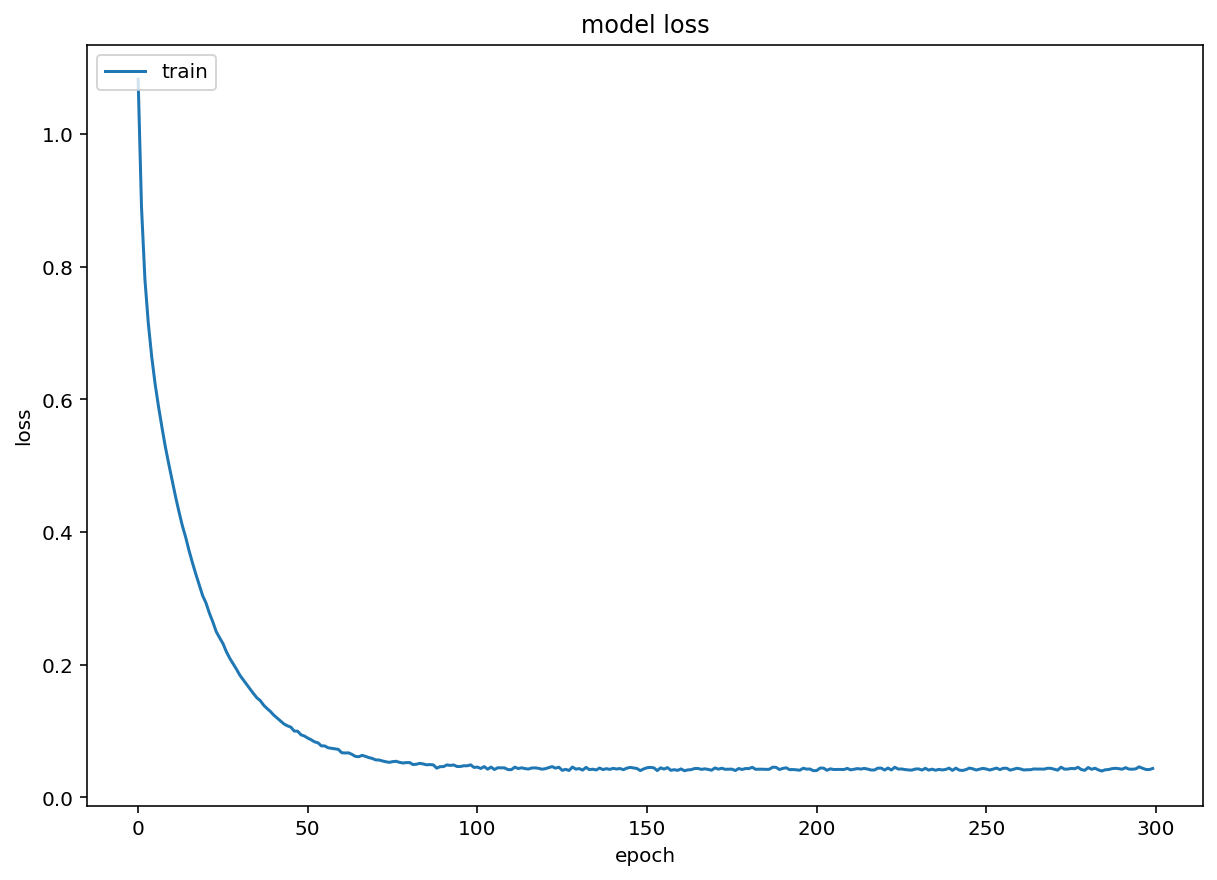

In [16]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [17]:
def split_batch_predict(data, num_qubits, model):
    
    splitted_X = None

    if num_qubits > 1:
        num_sections = ceil(X_.shape[0] / num_qubits)
        splitted_X = np.array_split(data.flatten(), num_sections)
    else:
        splitted_X = data

    y_prediction = []

    for arr in splitted_X:
        pred = model.predict(arr)
        y_prediction.append(pred.tolist())
    
    return np.array(y_prediction)

In [18]:
y_predict = split_batch_predict(X_, n_qubits, model)

In [19]:
y_predict_smooth = smooth(y_predict)

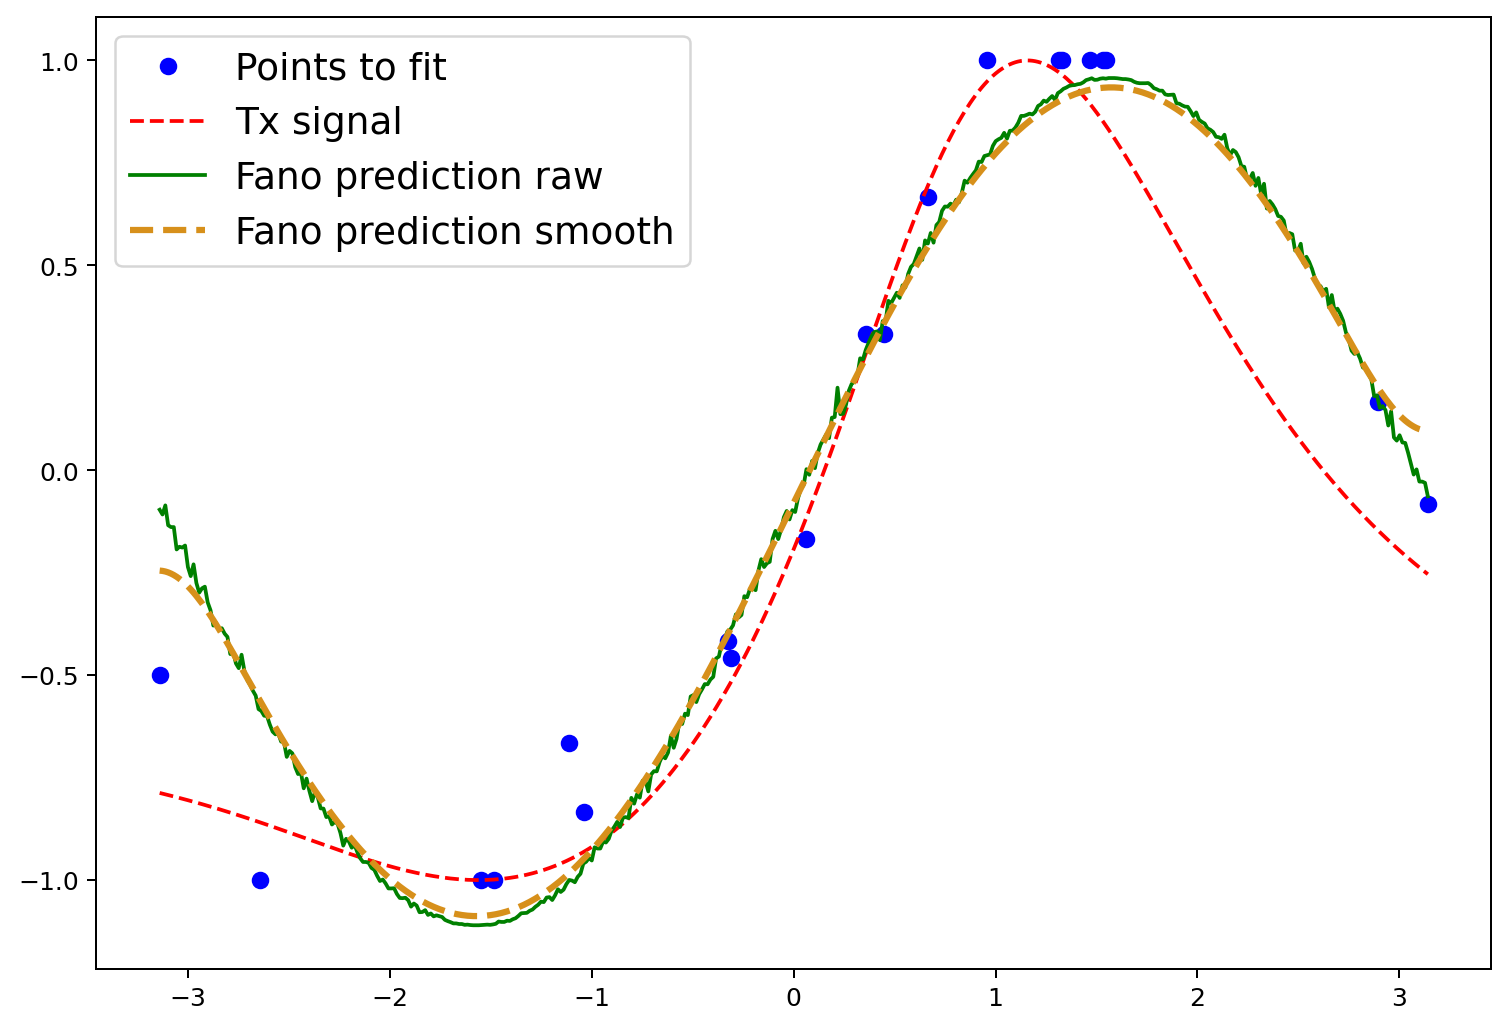

In [20]:
plt.figure(num = "Fano adjust QML 1", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')

# plot data
plt.plot(XX, yy, "bo", label = 'Points to fit')

# plot target function
plt.plot(X_, y_, "r--", label = 'Tx signal')

# plot prediction
plt.plot(X_, y_predict.flatten(), "g-", label = 'Fano prediction raw')
plt.plot(X_, y_predict_smooth.flatten(), "--", color='#d7901b', linewidth=2.5, label = 'Fano prediction smooth')
plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

In [21]:
print("Score: %.10f" % r2_score(y_, y_predict.flatten()))

Score: 0.8701895798


In [22]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright